In [2]:
import nomic
import json
api_key_path = "/home/ubuntu/api_keys.json"

with open(api_key_path, 'r') as j:
    key = json.loads(j.read())['nomic']

nomic.login(key)

from nomic import AtlasDataset
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
from fuzzywuzzy import fuzz

dataset = AtlasDataset('hivemind/tweets-from-members-of-us-congress-from-all-time-updated-2024-05-29')

embds = dataset.maps[0].embeddings.latent
df = dataset.maps[0].data.df

2024-06-08 18:11:53.541 | INFO     | nomic.dataset:__init__:829 - Loading existing dataset `hivemind/tweets-from-members-of-us-congress-from-all-time-updated-2024-05-29`.
100%|██████████████████████████████████████████████████████████████████████████████| 129/129 [00:00<00:00, 21444.46it/s]


In [3]:
congress_names, tweets_per_congress_person = np.unique(list(df['name']), return_counts=True)
congress_names = list(congress_names)
congress_handles = [list(df['twitter_lower'][df['name'] == cn])[0] for cn in congress_names]

average_embds = np.zeros((len(congress_names), embds.shape[1]))
party_by_congress_person = [-1 for cp in congress_names]

for i, embd in enumerate(tqdm(embds)):
    congress_name_index = congress_names.index(df['name'][i])
    average_embds[congress_name_index] += embd

    if party_by_congress_person[congress_name_index] == -1:
        party_by_congress_person[congress_name_index] = df['party'][i].lower()

average_embds = np.divide(average_embds, tweets_per_congress_person.reshape(-1, 1))
unique_party_labels, party_counts = np.unique(party_by_congress_person, return_counts=True)

100%|██████████████████████████████████████████████████████████████████████| 3037316/3037316 [01:48<00:00, 28003.11it/s]


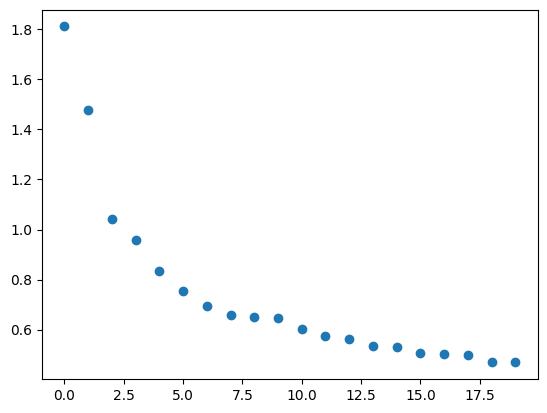

In [9]:
from graspologic.embed import ClassicalMDS
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

CMDS = ClassicalMDS(n_components=20)
cmds_embds = CMDS.fit_transform(average_embds)
singular_values = CMDS.singular_values_

CMDS = ClassicalMDS()
cmds_embds = CMDS.fit_transform(average_embds)

LDA = LinearDiscriminantAnalysis()
LDA.fit(cmds_embds, party_by_congress_person)
lda_embds = LDA.transform(cmds_embds)

colors = {
    'd': 'b',
    'r': 'r',
    'i': 'g'
         }

fig, ax = plt.subplots(1,1)
ax.scatter(range(len(singular_values)), singular_values)

Text(0.5, 1.05, 'Representations of Congressional Tweeters \nbased on average embedding of tweets')

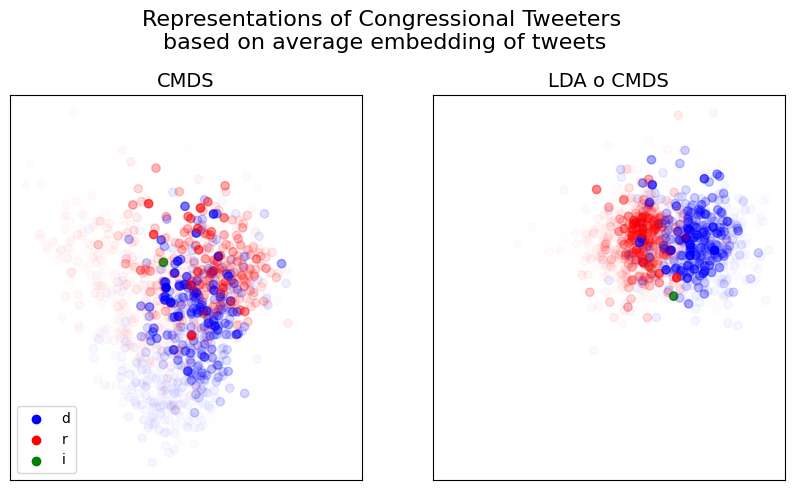

In [10]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
color_by_congress_person = [colors[p] for p in party_by_congress_person]
boldness_by_congress_person = tweets_per_congress_person / max(tweets_per_congress_person)

ax[0].scatter(cmds_embds[:, 0], cmds_embds[:, 1], 
              c=color_by_congress_person, 
              alpha=boldness_by_congress_person)
ax[0].set_title('CMDS', fontsize=14)
xlim, ylim = ax[0].get_xlim(), ax[0].get_ylim()

for label,color in colors.items():
    ax[0].scatter(1e5, 1e5, label=label, color=color)

ax[0].set_xlim(*xlim)
ax[0].set_ylim(*ylim)

ax[0].legend()

ax[1].scatter(lda_embds[:, 0], lda_embds[:, 1], c=color_by_congress_person, alpha=boldness_by_congress_person)
ax[1].set_title('LDA o CMDS', fontsize=14)

for ax_ in ax:
    ax_.set_yticks([])
    ax_.set_xticks([])

fig.suptitle('Representations of Congressional Tweeters \nbased on average embedding of tweets', fontsize=16, y=1.05)

In [11]:
df_vote_result = pd.read_csv('/home/ubuntu/congress_votes_118-2024_h142.csv', header=1)

matched_name = []
average_embd = []
handles = []
party= []

for i, row in df_vote_result.iterrows():
    voter_name = row['name']
    highest_ratio_index = np.argmax([fuzz.token_sort_ratio(voter_name, name) for name in congress_names])

    matched_name.append(congress_names[highest_ratio_index])
    average_embd.append(average_embds[highest_ratio_index])
    handles.append(congress_handles[highest_ratio_index])
    party.append(party_by_congress_person[highest_ratio_index])

df_vote_result['matched-name'] = matched_name
df_vote_result['twitter-handle'] = handles
df_vote_result['party'] = party
df_vote_result['average-embd'] = average_embd

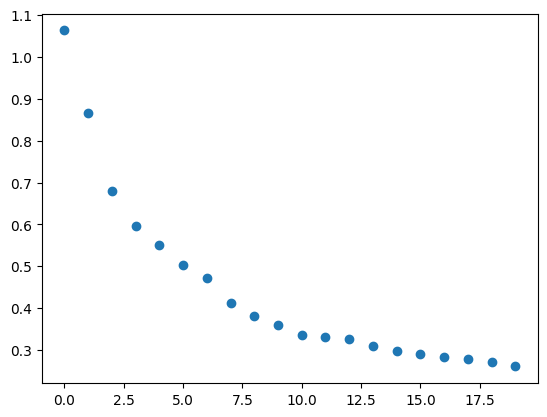

In [29]:
#- Now just looking at vote data

vote_embds = np.array(list(df_vote_result['average-embd']))

CMDS = ClassicalMDS(n_components=20)
cmds_embds = CMDS.fit_transform(vote_embds)
singular_values = CMDS.singular_values_

CMDS = ClassicalMDS()
cmds_embds = CMDS.fit_transform(vote_embds)

vote_by_congress_person = np.array(list(df_vote_result['vote']))
vote_by_congress_person = [v.lower().strip() for v in vote_by_congress_person]
vote_by_congress_person_binary = []

for v in vote_by_congress_person:
    if v == 'nay':
        vb=0
    elif v == 'yea':
        vb=1
    else:
        vb=-1
    vote_by_congress_person_binary.append(vb)
vote_by_congress_person_binary = np.array(vote_by_congress_person_binary)
voted_inds = vote_by_congress_person_binary != -1
    
LDA = LinearDiscriminantAnalysis()
LDA.fit(cmds_embds[voted_inds], np.array(vote_by_congress_person)[voted_inds])
lda_embds = LDA.transform(cmds_embds)

vote_colors = {
    'yea': 'orange',
    'nay': 'purple',
    'not voting': 'k'
         }

party_colors = {
    'r': 'r',
    'd': 'b',
    'i': 'g'
         }

fig, ax = plt.subplots(1,1)
ax.scatter(range(len(singular_values)), singular_values)

Text(0.5, 1.05, 'Representations of Congressional Tweeters \nbased on average embedding of tweets')

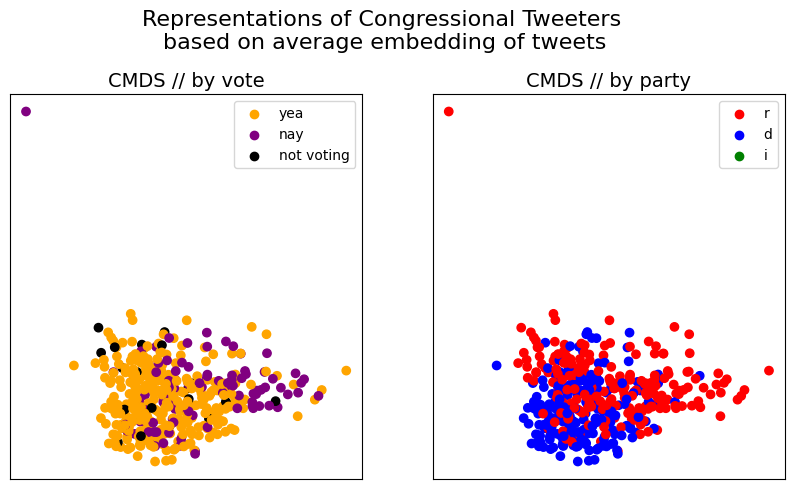

In [41]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
color_by_congress_person = [vote_colors[p] for p in vote_by_congress_person]
boldness_by_congress_person = tweets_per_congress_person / max(tweets_per_congress_person)

ax[0].scatter(cmds_embds[:, 0], cmds_embds[:, 1], 
              c=color_by_congress_person)
ax[0].set_title('CMDS // by vote', fontsize=14)
xlim, ylim = ax[0].get_xlim(), ax[0].get_ylim()

for label,color in vote_colors.items():
    ax[0].scatter(1e5, 1e5, label=label, color=color)

ax[0].set_xlim(*xlim)
ax[0].set_ylim(*ylim)

ax[0].legend()

color_by_congress_person = [party_colors[p] for p in df_vote_result['party']]
ax[1].scatter(cmds_embds[:, 0], cmds_embds[:, 1], 
              c=color_by_congress_person)
ax[1].set_title('CMDS // by party', fontsize=14)
xlim, ylim = ax[1].get_xlim(), ax[1].get_ylim()

for label,color in party_colors.items():
    ax[1].scatter(1e5, 1e5, label=label, color=color)

ax[1].set_xlim(*xlim)
ax[1].set_ylim(*ylim)

ax[1].legend()

# ax[1].scatter(lda_embds[:, 0], vote_by_congress_person)
# ax[1].set_title('LDA o CMDS', fontsize=14)

for ax_ in ax:
    ax_.set_yticks([])
    ax_.set_xticks([])

fig.suptitle('Representations of Congressional Tweeters \nbased on average embedding of tweets', fontsize=16, y=1.05)

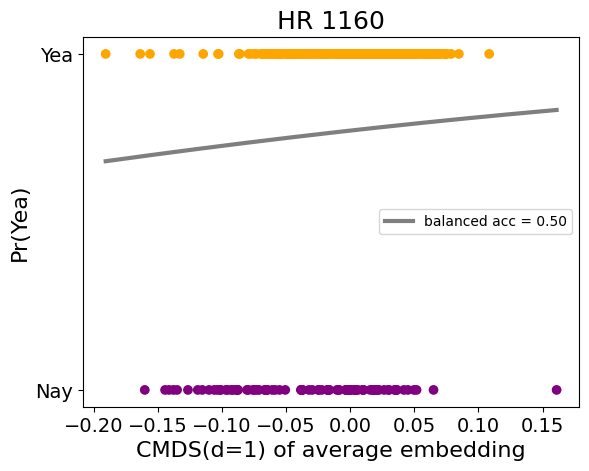

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score as bas

x = -1* cmds_embds[:, 0].reshape(-1,1)[voted_inds]
y = vote_by_congress_person_binary[voted_inds]

fig, ax = plt.subplots(1,1)

model = LogisticRegression()
model.fit(x, y)

X_test = np.linspace(min(x), max(x), 300).reshape(-1, 1)

# Predict probabilities using the logistic regression model
y_prob = model.predict_proba(X_test)[:, 1]

# Plot the data points
color_list = np.array([vote_colors[v] for v in vote_by_congress_person])
plt.scatter(x, y, color=color_list[voted_inds])

# Plot the logistic regression curve
er = bas(y, model.predict(x))
plt.plot(X_test, y_prob, color='k', alpha=0.5, linewidth=3, label=f'balanced acc = {er:1.2f}')

# Label the axes and the plot
plt.xlabel('CMDS(d=1) of average embedding', fontsize=16)
plt.ylabel('Pr(Yea)', fontsize=16)

plt.yticks([0,1], ['Nay', 'Yea'])
plt.tick_params(labelsize=14)

plt.legend(loc='center right')

plt.title('HR 1160', fontsize=18)

# Show the plot
plt.show()

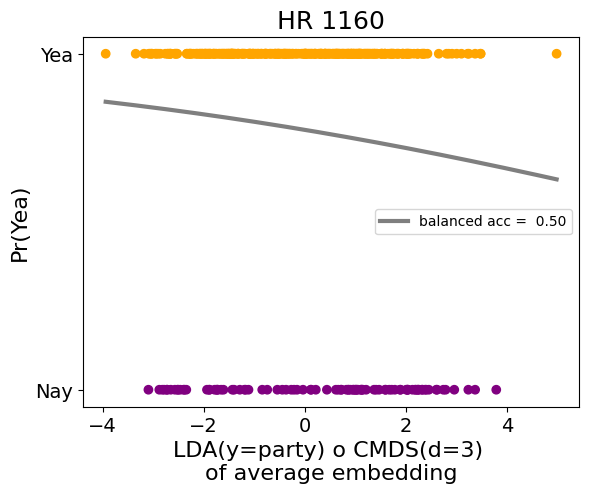

In [40]:
np.random.seed(1)

lda_model= LinearDiscriminantAnalysis()
lda_model.fit(cmds_embds[voted_inds], np.array(list(df_vote_result['party']))[voted_inds])

x=lda_model.transform(cmds_embds)[voted_inds, :1]
y = vote_by_congress_person_binary[voted_inds]

fig, ax = plt.subplots(1,1)

model = LogisticRegression()
model.fit(x, y)

X_test = np.linspace(min(x), max(x), 300).reshape(-1, 1)

# Predict probabilities using the logistic regression model
y_prob = model.predict_proba(X_test)[:, 1]

# Plot the data points
color_list = np.array([vote_colors[v] for v in vote_by_congress_person])
plt.scatter(x, y, color=color_list[voted_inds])

# Plot the logistic regression curve
er = bas(y, model.predict(x))
plt.plot(X_test, y_prob, color='k', alpha=0.5, linewidth=3, label=f'balanced acc = {er: 1.2f}')

# Label the axes and the plot
plt.xlabel('LDA(y=party) o CMDS(d=3) \nof average embedding', fontsize=16)
plt.ylabel('Pr(Yea)', fontsize=16)

plt.yticks([0,1], ['Nay', 'Yea'])
plt.tick_params(labelsize=14)

plt.legend(loc='center right')

plt.title('HR 1160', fontsize=18)

# Show the plot
plt.show()